# Blocking identifiaction with the Reversal index

In [1]:
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib import cm
import sys, os
sys.path.append("/home/b/b382006/tools/Blocking/brunner/blocking/")
from BlockingDetection import Blocking
import dask

#filters and units
from scipy.ndimage import gaussian_filter
import cartopy.util as cutil

import cartopy.feature as cf
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable

### many warnings problem | use size to dertimine dimensions
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sys.path.append('/home/b/b382006/tools/util')
from cpt_convert import loadCPT # Import the CPT convert function
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps

### ERA5

In [ ]:
# copy only 1990 to 2019 to compare with IFS
#! ln -s /work/bm1235/b382006/era5/z500/era5_regio_prl_199* /scratch/b/b382006/obs/era5/z500
#! ln -s /work/bm1235/b382006/era5/z500/era5_regio_prl_200* /scratch/b/b382006/obs/era5/z500
#! ln -s /work/bm1235/b382006/era5/z500/era5_regio_prl_201* /scratch/b/b382006/obs/era5/z500
### temporary repository 
inpath='/scratch/b/b382006/obs/era5/z500/'
outpath='/scratch/b/b382006/obs/era5/block/ABS_500_DAV' ## ABS_Z500, ABS_Z500_DAV


In [3]:
xr_in=xr.open_mfdataset(inpath+'era5_*')
# preprocessing
### To daily to compare with nextGEMS
daily_z = xr_in.resample(time='D').mean().compute()
#xr_in.to_netcdf(inpath+'/era5_daily.nc')
xr_in.close()
del xr_in
daily_z

<xarray.Dataset> Size: 6GB
Dimensions:    (time: 10957, latitude: 181, longitude: 360)
Coordinates:
  * longitude  (longitude) float32 1kB -180.0 -179.0 -178.0 ... 178.0 179.0
  * latitude   (latitude) float32 724B 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 88kB 1990-01-01 1990-01-02 ... 2019-12-31
Data variables:
    z          (time, latitude, longitude) float64 6GB 5.118e+04 ... 5.008e+04
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-14 14:59:19 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [4]:
### years
yy0=int(daily_z['time'].time[0].dt.year)
yyn=int(daily_z['time'].time[-1].dt.year)
years=np.arange(yy0,yyn+1,1)
print(years)

[1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019]


In [ ]:
for year in years:
    ofile= "block_ABS-Z500_"+str(year)+".nc"

    if not os.path.exists(outpath):
        os.makedirs(outpath)
    OUTPATH=outpath+'/'+ofile

    print(OUTPATH)

    data=daily_z.sel(time=daily_z.time.dt.year.isin([year]))

#    print(data)
    ### intitate
    blk = Blocking()

    blk.import_xarray(data)

    blk.calculate_gph_from_gp() # calculate geopotential height

    blk.set_up(time_name='time', longitude_name='longitude', latitude_name='latitude')

    ### Davini
    blk.calculate_gradients(delta_degree=15)

    blk.calculate_ib(
    gradient_equator_below=0,
    gradient_pole_below=-10,
    gradient_equator2_above=None)

    blk.calculate_eib(min_extent_degree=15)

    blk.calculate_blocking(
    stationary_pm_days=2,
    longitude_pm_degree=8,
    latitude_pm_degree=2)

# save to disk
    blk
    blk.save(OUTPATH, 'Blocking')

    data.close()

2025-04-02 10:39:57,802 - root - INFO - Calculated GPH from GP
2025-04-02 10:39:57,803 - root - INFO - Set time grid distance 1
2025-04-02 10:39:57,806 - root - INFO - Set longitude grid distance 1.0
2025-04-02 10:39:57,807 - root - WARNING - latitude grid not increasing. Inverse dimension!


/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_1990.nc


2025-04-02 10:39:57,948 - root - INFO - Set latitude grid distance 1.0
2025-04-02 10:39:57,961 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 10:39:58,576 - root - INFO - Calculating gradients... DONE
2025-04-02 10:39:58,577 - root - INFO - Calculating IB as IB...
2025-04-02 10:39:59,014 - root - INFO - Calculating IB... DONE
2025-04-02 10:39:59,014 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 10:40:00,619 - root - INFO - Calculating extended IB... DONE
2025-04-02 10:40:00,620 - root - INFO - Calculating blocking as Blocking...
2025-04-02 10:40:00,743 - root - INFO - Calculating time step... 0%
2025-04-02 10:41:32,097 - root - INFO - Calculating time step... 10%
2025-04-02 10:42:25,654 - root - INFO - Calculating time step... 20%
2025-04-02 10:43:41,748 - root - INFO - Calculating time step... 30%
2025-04-02 10:44:51,065 - root - INFO - Calculating time step... 40%
2025-04-02 10:46:41,204 - root - INFO - Calculating time step... 5

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_1991.nc


2025-04-02 10:54:45,750 - root - INFO - Calculated GPH from GP
2025-04-02 10:54:45,763 - root - INFO - Set time grid distance 1
2025-04-02 10:54:45,777 - root - INFO - Set longitude grid distance 1.0
2025-04-02 10:54:45,779 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 10:54:45,910 - root - INFO - Set latitude grid distance 1.0
2025-04-02 10:54:45,920 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 10:54:46,538 - root - INFO - Calculating gradients... DONE
2025-04-02 10:54:46,540 - root - INFO - Calculating IB as IB...
2025-04-02 10:54:46,990 - root - INFO - Calculating IB... DONE
2025-04-02 10:54:46,991 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 10:54:48,715 - root - INFO - Calculating extended IB... DONE
2025-04-02 10:54:48,716 - root - INFO - Calculating blocking as Blocking...
2025-04-02 10:54:48,845 - root - INFO - Calculating time step... 0%
2025-04-02 10:56:25,663 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_1992.nc


2025-04-02 11:11:15,955 - root - INFO - Calculated GPH from GP
2025-04-02 11:11:15,992 - root - INFO - Set time grid distance 1
2025-04-02 11:11:16,033 - root - INFO - Set longitude grid distance 1.0
2025-04-02 11:11:16,035 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 11:11:16,169 - root - INFO - Set latitude grid distance 1.0
2025-04-02 11:11:16,179 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 11:11:16,791 - root - INFO - Calculating gradients... DONE
2025-04-02 11:11:16,792 - root - INFO - Calculating IB as IB...
2025-04-02 11:11:17,264 - root - INFO - Calculating IB... DONE
2025-04-02 11:11:17,264 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 11:11:18,960 - root - INFO - Calculating extended IB... DONE
2025-04-02 11:11:18,961 - root - INFO - Calculating blocking as Blocking...
2025-04-02 11:11:19,089 - root - INFO - Calculating time step... 0%
2025-04-02 11:12:34,667 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_1993.nc


2025-04-02 11:26:25,992 - root - INFO - Calculated GPH from GP
2025-04-02 11:26:26,002 - root - INFO - Set time grid distance 1
2025-04-02 11:26:26,020 - root - INFO - Set longitude grid distance 1.0
2025-04-02 11:26:26,021 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 11:26:26,155 - root - INFO - Set latitude grid distance 1.0
2025-04-02 11:26:26,167 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 11:26:26,788 - root - INFO - Calculating gradients... DONE
2025-04-02 11:26:26,789 - root - INFO - Calculating IB as IB...
2025-04-02 11:26:27,242 - root - INFO - Calculating IB... DONE
2025-04-02 11:26:27,243 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 11:26:28,930 - root - INFO - Calculating extended IB... DONE
2025-04-02 11:26:28,931 - root - INFO - Calculating blocking as Blocking...
2025-04-02 11:26:29,061 - root - INFO - Calculating time step... 0%
2025-04-02 11:28:09,910 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_1994.nc


2025-04-02 11:41:55,362 - root - INFO - Calculated GPH from GP
2025-04-02 11:41:55,366 - root - INFO - Set time grid distance 1
2025-04-02 11:41:55,370 - root - INFO - Set longitude grid distance 1.0
2025-04-02 11:41:55,370 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 11:41:55,505 - root - INFO - Set latitude grid distance 1.0
2025-04-02 11:41:55,518 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 11:41:56,119 - root - INFO - Calculating gradients... DONE
2025-04-02 11:41:56,120 - root - INFO - Calculating IB as IB...
2025-04-02 11:41:56,569 - root - INFO - Calculating IB... DONE
2025-04-02 11:41:56,570 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 11:41:58,284 - root - INFO - Calculating extended IB... DONE
2025-04-02 11:41:58,285 - root - INFO - Calculating blocking as Blocking...
2025-04-02 11:41:58,413 - root - INFO - Calculating time step... 0%
2025-04-02 11:43:23,801 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_1995.nc


2025-04-02 11:57:14,450 - root - INFO - Calculated GPH from GP
2025-04-02 11:57:14,457 - root - INFO - Set time grid distance 1
2025-04-02 11:57:14,484 - root - INFO - Set longitude grid distance 1.0
2025-04-02 11:57:14,484 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 11:57:14,630 - root - INFO - Set latitude grid distance 1.0
2025-04-02 11:57:14,642 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 11:57:15,300 - root - INFO - Calculating gradients... DONE
2025-04-02 11:57:15,301 - root - INFO - Calculating IB as IB...
2025-04-02 11:57:15,749 - root - INFO - Calculating IB... DONE
2025-04-02 11:57:15,750 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 11:57:17,466 - root - INFO - Calculating extended IB... DONE
2025-04-02 11:57:17,467 - root - INFO - Calculating blocking as Blocking...
2025-04-02 11:57:17,596 - root - INFO - Calculating time step... 0%
2025-04-02 12:00:29,948 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_1996.nc


2025-04-02 12:13:37,410 - root - INFO - Calculated GPH from GP
2025-04-02 12:13:37,414 - root - INFO - Set time grid distance 1
2025-04-02 12:13:37,418 - root - INFO - Set longitude grid distance 1.0
2025-04-02 12:13:37,418 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 12:13:37,554 - root - INFO - Set latitude grid distance 1.0
2025-04-02 12:13:37,566 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 12:13:38,171 - root - INFO - Calculating gradients... DONE
2025-04-02 12:13:38,172 - root - INFO - Calculating IB as IB...
2025-04-02 12:13:38,618 - root - INFO - Calculating IB... DONE
2025-04-02 12:13:38,618 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 12:13:40,254 - root - INFO - Calculating extended IB... DONE
2025-04-02 12:13:40,255 - root - INFO - Calculating blocking as Blocking...
2025-04-02 12:13:40,383 - root - INFO - Calculating time step... 0%
2025-04-02 12:15:30,381 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_1997.nc


2025-04-02 12:29:19,588 - root - INFO - Calculated GPH from GP
2025-04-02 12:29:19,599 - root - INFO - Set time grid distance 1
2025-04-02 12:29:19,624 - root - INFO - Set longitude grid distance 1.0
2025-04-02 12:29:19,624 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 12:29:19,760 - root - INFO - Set latitude grid distance 1.0
2025-04-02 12:29:19,773 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 12:29:20,366 - root - INFO - Calculating gradients... DONE
2025-04-02 12:29:20,367 - root - INFO - Calculating IB as IB...
2025-04-02 12:29:20,812 - root - INFO - Calculating IB... DONE
2025-04-02 12:29:20,812 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 12:29:22,607 - root - INFO - Calculating extended IB... DONE
2025-04-02 12:29:22,608 - root - INFO - Calculating blocking as Blocking...
2025-04-02 12:29:22,735 - root - INFO - Calculating time step... 0%
2025-04-02 12:31:23,702 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_1998.nc


2025-04-02 12:47:06,261 - root - INFO - Calculated GPH from GP
2025-04-02 12:47:06,265 - root - INFO - Set time grid distance 1
2025-04-02 12:47:06,268 - root - INFO - Set longitude grid distance 1.0
2025-04-02 12:47:06,269 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 12:47:06,405 - root - INFO - Set latitude grid distance 1.0
2025-04-02 12:47:06,418 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 12:47:07,011 - root - INFO - Calculating gradients... DONE
2025-04-02 12:47:07,011 - root - INFO - Calculating IB as IB...
2025-04-02 12:47:07,458 - root - INFO - Calculating IB... DONE
2025-04-02 12:47:07,458 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 12:47:09,283 - root - INFO - Calculating extended IB... DONE
2025-04-02 12:47:09,284 - root - INFO - Calculating blocking as Blocking...
2025-04-02 12:47:09,411 - root - INFO - Calculating time step... 0%
2025-04-02 12:48:56,614 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_1999.nc


2025-04-02 13:05:38,415 - root - INFO - Calculated GPH from GP
2025-04-02 13:05:38,418 - root - INFO - Set time grid distance 1
2025-04-02 13:05:38,421 - root - INFO - Set longitude grid distance 1.0
2025-04-02 13:05:38,422 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 13:05:38,557 - root - INFO - Set latitude grid distance 1.0
2025-04-02 13:05:38,569 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 13:05:39,158 - root - INFO - Calculating gradients... DONE
2025-04-02 13:05:39,159 - root - INFO - Calculating IB as IB...
2025-04-02 13:05:39,596 - root - INFO - Calculating IB... DONE
2025-04-02 13:05:39,597 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 13:05:41,286 - root - INFO - Calculating extended IB... DONE
2025-04-02 13:05:41,286 - root - INFO - Calculating blocking as Blocking...
2025-04-02 13:05:41,414 - root - INFO - Calculating time step... 0%
2025-04-02 13:07:35,153 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_2000.nc


2025-04-02 13:22:16,501 - root - INFO - Calculated GPH from GP
2025-04-02 13:22:16,504 - root - INFO - Set time grid distance 1
2025-04-02 13:22:16,507 - root - INFO - Set longitude grid distance 1.0
2025-04-02 13:22:16,508 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 13:22:16,651 - root - INFO - Set latitude grid distance 1.0
2025-04-02 13:22:16,663 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 13:22:17,515 - root - INFO - Calculating gradients... DONE
2025-04-02 13:22:17,558 - root - INFO - Calculating IB as IB...
2025-04-02 13:22:18,062 - root - INFO - Calculating IB... DONE
2025-04-02 13:22:18,063 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 13:22:19,729 - root - INFO - Calculating extended IB... DONE
2025-04-02 13:22:19,730 - root - INFO - Calculating blocking as Blocking...
2025-04-02 13:22:19,861 - root - INFO - Calculating time step... 0%
2025-04-02 13:24:02,086 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_2001.nc


2025-04-02 13:39:05,660 - root - INFO - Calculated GPH from GP
2025-04-02 13:39:05,662 - root - INFO - Set time grid distance 1
2025-04-02 13:39:05,665 - root - INFO - Set longitude grid distance 1.0
2025-04-02 13:39:05,666 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 13:39:05,823 - root - INFO - Set latitude grid distance 1.0
2025-04-02 13:39:05,836 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 13:39:06,447 - root - INFO - Calculating gradients... DONE
2025-04-02 13:39:06,448 - root - INFO - Calculating IB as IB...
2025-04-02 13:39:06,896 - root - INFO - Calculating IB... DONE
2025-04-02 13:39:06,896 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 13:39:08,562 - root - INFO - Calculating extended IB... DONE
2025-04-02 13:39:08,563 - root - INFO - Calculating blocking as Blocking...
2025-04-02 13:39:08,687 - root - INFO - Calculating time step... 0%
2025-04-02 13:41:05,576 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_2002.nc


2025-04-02 13:55:48,751 - root - INFO - Calculated GPH from GP
2025-04-02 13:55:48,756 - root - INFO - Set time grid distance 1
2025-04-02 13:55:48,759 - root - INFO - Set longitude grid distance 1.0
2025-04-02 13:55:48,760 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 13:55:48,898 - root - INFO - Set latitude grid distance 1.0
2025-04-02 13:55:48,911 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 13:55:49,539 - root - INFO - Calculating gradients... DONE
2025-04-02 13:55:49,539 - root - INFO - Calculating IB as IB...
2025-04-02 13:55:49,994 - root - INFO - Calculating IB... DONE
2025-04-02 13:55:49,995 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 13:55:51,960 - root - INFO - Calculating extended IB... DONE
2025-04-02 13:55:51,974 - root - INFO - Calculating blocking as Blocking...
2025-04-02 13:55:52,100 - root - INFO - Calculating time step... 0%
2025-04-02 13:57:31,346 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_2003.nc


2025-04-02 14:13:21,383 - root - INFO - Calculated GPH from GP
2025-04-02 14:13:21,386 - root - INFO - Set time grid distance 1
2025-04-02 14:13:21,389 - root - INFO - Set longitude grid distance 1.0
2025-04-02 14:13:21,390 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 14:13:21,536 - root - INFO - Set latitude grid distance 1.0
2025-04-02 14:13:21,548 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 14:13:22,200 - root - INFO - Calculating gradients... DONE
2025-04-02 14:13:22,201 - root - INFO - Calculating IB as IB...
2025-04-02 14:13:22,658 - root - INFO - Calculating IB... DONE
2025-04-02 14:13:22,658 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 14:13:24,338 - root - INFO - Calculating extended IB... DONE
2025-04-02 14:13:24,338 - root - INFO - Calculating blocking as Blocking...
2025-04-02 14:13:24,464 - root - INFO - Calculating time step... 0%
2025-04-02 14:15:26,734 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_2004.nc


2025-04-02 14:30:43,437 - root - INFO - Calculated GPH from GP
2025-04-02 14:30:43,455 - root - INFO - Set time grid distance 1
2025-04-02 14:30:43,490 - root - INFO - Set longitude grid distance 1.0
2025-04-02 14:30:43,494 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 14:30:43,646 - root - INFO - Set latitude grid distance 1.0
2025-04-02 14:30:43,656 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 14:30:44,254 - root - INFO - Calculating gradients... DONE
2025-04-02 14:30:44,254 - root - INFO - Calculating IB as IB...
2025-04-02 14:30:44,710 - root - INFO - Calculating IB... DONE
2025-04-02 14:30:44,710 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 14:30:46,305 - root - INFO - Calculating extended IB... DONE
2025-04-02 14:30:46,305 - root - INFO - Calculating blocking as Blocking...
2025-04-02 14:30:46,433 - root - INFO - Calculating time step... 0%
2025-04-02 14:32:07,218 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_2005.nc


2025-04-02 14:46:49,172 - root - INFO - Calculated GPH from GP
2025-04-02 14:46:49,175 - root - INFO - Set time grid distance 1
2025-04-02 14:46:49,180 - root - INFO - Set longitude grid distance 1.0
2025-04-02 14:46:49,181 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 14:46:49,312 - root - INFO - Set latitude grid distance 1.0
2025-04-02 14:46:49,322 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 14:46:49,907 - root - INFO - Calculating gradients... DONE
2025-04-02 14:46:49,908 - root - INFO - Calculating IB as IB...
2025-04-02 14:46:50,344 - root - INFO - Calculating IB... DONE
2025-04-02 14:46:50,345 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 14:46:51,997 - root - INFO - Calculating extended IB... DONE
2025-04-02 14:46:51,997 - root - INFO - Calculating blocking as Blocking...
2025-04-02 14:46:52,124 - root - INFO - Calculating time step... 0%
2025-04-02 14:48:44,386 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_2006.nc


2025-04-02 15:04:13,702 - root - INFO - Calculated GPH from GP
2025-04-02 15:04:13,719 - root - INFO - Set time grid distance 1
2025-04-02 15:04:13,737 - root - INFO - Set longitude grid distance 1.0
2025-04-02 15:04:13,740 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 15:04:13,874 - root - INFO - Set latitude grid distance 1.0
2025-04-02 15:04:13,885 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 15:04:14,477 - root - INFO - Calculating gradients... DONE
2025-04-02 15:04:14,478 - root - INFO - Calculating IB as IB...
2025-04-02 15:04:14,985 - root - INFO - Calculating IB... DONE
2025-04-02 15:04:14,986 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 15:04:16,588 - root - INFO - Calculating extended IB... DONE
2025-04-02 15:04:16,589 - root - INFO - Calculating blocking as Blocking...
2025-04-02 15:04:16,766 - root - INFO - Calculating time step... 0%
2025-04-02 15:06:21,702 - root - INFO - Calculatin

/scratch/b/b382006/obs/era5/block/ABS_500_DAV/block_ABS-Z500_2007.nc


2025-04-02 15:20:57,976 - root - INFO - Calculated GPH from GP
2025-04-02 15:20:57,984 - root - INFO - Set time grid distance 1
2025-04-02 15:20:57,997 - root - INFO - Set longitude grid distance 1.0
2025-04-02 15:20:57,998 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 15:20:58,135 - root - INFO - Set latitude grid distance 1.0
2025-04-02 15:20:58,148 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 15:20:58,794 - root - INFO - Calculating gradients... DONE
2025-04-02 15:20:59,068 - root - INFO - Calculating IB as IB...
2025-04-02 15:21:00,177 - root - INFO - Calculating IB... DONE
2025-04-02 15:21:00,185 - root - INFO - Calculating extended IB as ExtendedIB...
2025-04-02 15:21:01,898 - root - INFO - Calculating extended IB... DONE
2025-04-02 15:21:01,899 - root - INFO - Calculating blocking as Blocking...
2025-04-02 15:21:02,039 - root - INFO - Calculating time step... 0%
2025-04-02 15:22:44,749 - root - INFO - Calculatin

In [ ]:
### full data

In [ ]:

### intitate
blk = Blocking()

blk.import_xarray(xr_in)

###era5
blk.calculate_gph_from_gp() # calculate geopotential height

blk.set_up(time_name='time', longitude_name='longitude', latitude_name='latitude')

'''
### Brunner
blk.calculate_gradients(delta_degree=15)

blk.calculate_ib(
    gradient_equator_below=0,
    gradient_pole_below=-10,
    gradient_equator2_above=5)

# 
blk.calculate_eib(min_extent_degree=15)
# 
blk.calculate_blocking(
    stationary_pm_days=2,
    longitude_pm_degree=8,
    latitude_pm_degree=2)

OUTPATH=outpath+'ABS_Z500/IB.nc'
OUTPATH2=outpath+'ABS_Z500/ExtendB.nc'
OUTPATH3=outpath+'ABS_Z500/BLOCKS'+subfix+'.nc'

####
'''

### Davini
blk.calculate_gradients(delta_degree=15)

blk.calculate_ib(
    gradient_equator_below=0,
    gradient_pole_below=-10,
    gradient_equator2_above=None)

blk.calculate_eib(min_extent_degree=15)

blk.calculate_blocking(
    stationary_pm_days=2,
    longitude_pm_degree=8,
    latitude_pm_degree=2)

OUTPATH=outpath+'/IB.nc'
OUTPATH2=outpath+'/ExtendB.nc'
OUTPATH3=outpath+'/BLOCKS'+subfix+'.nc'

###

### years
yy0=int(xr_in['time'].time[0].dt.year)
yyn=int(xr_in['time'].time[-1].dt.year)

subfix='-ERA5-'+str(yy0)+'-'+str(yyn)+''

print(yy0,yyn,OUTPATH3)

# save to disk 
blk.save(OUTPATH, 'IB')
blk.save(OUTPATH2, 'ExtendedIB')
blk.save(OUTPATH3, 'Blocking')


2025-04-02 10:15:56,946 - root - INFO - Set time grid distance 1
2025-04-02 10:15:56,949 - root - INFO - Set longitude grid distance 1.0
2025-04-02 10:15:56,950 - root - WARNING - latitude grid not increasing. Inverse dimension!
2025-04-02 10:16:04,755 - root - INFO - Set latitude grid distance 1.0
2025-04-02 10:16:05,189 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-04-02 10:16:28,600 - root - INFO - Calculating gradients... DONE
2025-04-02 10:16:28,699 - root - INFO - Calculating IB as IB...


### IFS simulations

In [16]:
### blocking method based on the original Code of Lukas Brunner
## nextGEMS
#inpath='/work/bm1235/b382006/nextgems/prefinal/'+id_exp+/ 
#id_exp='IFS_9-FESOM_5-production' #IFS_9-FESOM_5-production, IFS_9-FESOM_5-production-hist
#xr_in=xr.open_mfdataset(inpath+id_exp+'/z/6H/z500_'+id_exp+'_*')
## IFS AMIP
inpath='/scratch/b/b382006/EERIE/cycle1/'+id_exp+'/'
id_exp='ifs-amip-tco1279' #IFS_9-FESOM_5-production, IFS_9-FESOM_5-production-hist
xr_in=xr.open_mfdataset(inpath+'/z500/6H/z500_ifs_c1_*')
xr_in = xr_in.sel(time=slice('1990','2019')) ## only 30 years

In [ ]:
#xr_in['z'][0,...].plot()

In [13]:
daily_z = xr_in.resample(time='D').mean()#.compute()
daily_z

<xarray.Dataset> Size: 6GB
Dimensions:  (time: 10957, lat: 181, lon: 360)
Coordinates:
  * lat      (lat) int64 1kB -90 -89 -88 -87 -86 -85 -84 ... 85 86 87 88 89 90
  * lon      (lon) int64 3kB -180 -179 -178 -177 -176 ... 175 176 177 178 179
  * time     (time) datetime64[ns] 88kB 1990-01-01 1990-01-02 ... 2019-12-31
Data variables:
    z        (time, lat, lon) float64 6GB dask.array<chunksize=(1, 181, 360), meta=np.ndarray>

In [14]:
### some pre-processing

In [15]:
### take care of time format --> change to yyyy mm dd - daily icon/ifs
#xr_in['time']=xr_in.indexes['time'].normalize()

###=== rename zfull
#xr_in=xr_in.rename({'z':'GeopotentialHeight'})

###for era5
#dxr_in=xr_in.drop_dims('bnds')
#dxr_in

### Take geopotential
###icon
#in_z_500=xr_in.GeopotentialHeight.sel(plev=50000.0)
#daily_z=in_z_500.resample(time='1D').mean(dim='time',keep_attrs=True) #daily mean
#dataset_z=xr.DataArray.to_dataset(daily_z)
#dataset_z.GeopotentialHeight

###==era5
#dataset_z=xr_in.resample(time='1D').mean(dim='time',keep_attrs=True) #daily mean

#dataset_z.time.attrs['standard_name'] = 'time'
#dataset_z.time.attrs['axis'] = 'T'
#dataset_z.time

#xr_in.time.attrs['standard_name'] = 'time'
#xr_in.time.attrs['axis'] = 'T'
#xr_in.time

## DO we need to resample???
###xr_in=xr_in.resample(time='6H').mean(dim='time',keep_attrs=True) #6 hourly mean
#daily_z=xr_in.resample(time='1D').mean(dim='time',keep_attrs=True) #daily mean
#daily_z

### remove extra dimension level
#daily_z =xr_in.isel(level=0, drop=True)


In [18]:
#OUTPATH = dataset_z.replace(
#    'geopotential', 'blocking').replace('.nc', '_bf_3D.nc')
OUTPATH=inpath+'block/ABS_Z500/IB.nc'
OUTPATH2=inpath+'block/ABS_Z500/ExtendB.nc'
OUTPATH3=inpath+'block/ABS_Z500/blocking.nc'
yy0=int(daily_z['time'].time[0].dt.year)
yyn=int(daily_z['time'].time[-1].dt.year)
print(yy0,yyn,OUTPATH)
#inpath='/scratch/b/b382006/nextgems/prefinal/'+id_exp+'/'

1990 2019 /scratch/b/b382006/EERIE/cycle1/ifs-amip-tco1279/block/ABS_Z500/IB.nc


In [19]:
### intitate
blk = Blocking()
#blk.import_xarray(dataset_z)
blk.import_xarray(daily_z)
#blk.ds

## pre-processing
##blk.get_time_subset(months='DJF')
##blk.calculate_daily_mean()

###era5
blk.calculate_gph_from_gp() # calculate geopotential height

#blk.ds.time
#blk.ds.GeopotentialHeight
#blk.ds.GeopotentialHeight

2025-03-11 23:15:44,260 - root - INFO - Calculated GPH from GP


In [1]:
###

In [ ]:
blk.set_up(time_name='time', longitude_name='lon', latitude_name='lat')

blk.calculate_gradients(delta_degree=15)

blk.calculate_ib(
    gradient_equator_below=0,
    gradient_pole_below=-10,
    gradient_equator2_above=5)

# 
blk.calculate_eib(min_extent_degree=15)
# 
blk.calculate_blocking(
    stationary_pm_days=2,
    longitude_pm_degree=8,
    latitude_pm_degree=2)

# save to disk 
blk.save(OUTPATH, 'IB')
blk.save(OUTPATH2, 'ExtendedIB')
blk.save(OUTPATH3, 'Blocking')

2025-03-11 23:15:53,125 - root - INFO - Set time grid distance 1
2025-03-11 23:15:53,140 - root - INFO - Set lon grid distance 1
2025-03-11 23:15:53,141 - root - INFO - Set lat grid distance 1
2025-03-11 23:15:53,145 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-03-11 23:16:01,404 - root - INFO - Calculating gradients... DONE
2025-03-11 23:16:01,429 - root - INFO - Calculating IB as IB...
2025-03-11 23:20:52,356 - root - INFO - Calculating IB... DONE
2025-03-11 23:20:52,393 - root - INFO - Calculating extended IB as ExtendedIB...
2025-03-11 23:21:23,865 - root - INFO - Calculating extended IB... DONE
2025-03-11 23:21:23,950 - root - INFO - Calculating blocking as Blocking...
2025-03-11 23:21:27,319 - root - INFO - Calculating time step... 0%
2025-03-11 23:31:34,465 - root - INFO - Calculating time step... 10%
2025-03-11 23:40:16,678 - root - INFO - Calculating time step... 20%


In [ ]:
###
#daily_z['zg']

In [ ]:
###

### ICON simulations

In [1]:
### icon DestinE
'''
#########=== START Process for DestinE data
inpath='/scratch/b/b382006/icon-climate-dt/'
id_exp=''
tres='netcdf'

daily_z=xr.open_mfdataset(inpath+id_exp+'/zg/'+tres+'/*nc')

#########=== START Process for DestinE data
###==rename
daily_z=daily_z.rename({'longitude':'lon',
                  'latitude':'lat',
                  'forecast_reference_time':'time',
                       })

daily_z['z']=daily_z['z'].assign_attrs(units='m**2 s**-2')

### remove last months due to high missing numbers
daily_z=daily_z.sel(time=slice('1993-01','2012-09'))

### Daily mean
daily_z=daily_z.resample(time='D').mean().compute()

daily_z['z']=daily_z['z'].assign_attrs(_earthkit='none')
daily_z['z'].to_netcdf(inpath+id_exp+'/zg/daily/icon-climate-dt_zg_daily.nc')
'''
########====

"\n#########=== START Process for DestinE data\ninpath='/scratch/b/b382006/icon-climate-dt/'\nid_exp=''\ntres='netcdf'\n\ndaily_z=xr.open_mfdataset(inpath+id_exp+'/zg/'+tres+'/*nc')\n\n#########=== START Process for DestinE data\n###==rename\ndaily_z=daily_z.rename({'longitude':'lon',\n                  'latitude':'lat',\n                  'forecast_reference_time':'time',\n                       })\n\ndaily_z['z']=daily_z['z'].assign_attrs(units='m**2 s**-2')\n\n### remove last months due to high missing numbers\ndaily_z=daily_z.sel(time=slice('1993-01','2012-09'))\n\n### Daily mean\ndaily_z=daily_z.resample(time='D').mean().compute()\n\ndaily_z['z']=daily_z['z'].assign_attrs(_earthkit='none')\ndaily_z['z'].to_netcdf(inpath+id_exp+'/zg/daily/icon-climate-dt_zg_daily.nc')\n"

In [15]:
#daily_z#.to_netcdf(inpath+id_exp+'/zg/daily/icon-climate-dt_zg_daily.nc')
#daily_z['z']=daily_z['z'].assign_attrs(_earthkit='none')
#daily_z['z'].to_netcdf(inpath+id_exp+'/zg/daily/icon-climate-dt_zg_daily.nc')

In [ ]:
### icon production
#inpath='/scratch/b/b382006/nextgems/prefinal/'
#id_exp='ngc4008'
#tres='daily'

### icon DestinE
inpath='/scratch/b/b382006/icon-climate-dt/'
id_exp=''
tres='daily'

daily_z=xr.open_mfdataset(inpath+id_exp+'/zg/'+tres+'/icon-climate-dt_zg_daily.nc')
daily_z


# Now `GeopotentialHeight` replaces `zg` in production ngc4008 runs
#daily_z = daily_z.rename({'zg': 'GeopotentialHeight'})
#print(daily_z)

OUTPATH=inpath+id_exp+'/'+'block/ABS_Z500/IB.nc'
OUTPATH2=inpath+id_exp+'/'+'block/ABS_Z500/ExtendB.nc'
OUTPATH3=inpath+id_exp+'/'+'block/ABS_Z500/blocking.nc'

yy0=int(daily_z['time'].time[0].dt.year)
yyn=int(daily_z['time'].time[-1].dt.year)
print(yy0,yyn,OUTPATH3)

### intitate
blk = Blocking()
blk.import_xarray(daily_z)

## pre-processing
##blk.get_time_subset(months='DJF')
#blk.calculate_daily_mean()  ## DestinE

###era5
blk.calculate_gph_from_gp() # calculate geopotential height

### many warnings problem | use size to dertimine dimensions
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

blk.set_up(time_name='time', longitude_name='lon', latitude_name='lat')

blk.calculate_gradients(delta_degree=15)

blk.calculate_ib(
    gradient_equator_below=0,
    gradient_pole_below=-10,
    gradient_equator2_above=5)

# 
blk.calculate_eib(min_extent_degree=15)
# 
blk.calculate_blocking(
    stationary_pm_days=2,
    longitude_pm_degree=8,
    latitude_pm_degree=2)

# save to disk 
blk.save(OUTPATH, 'IB')
blk.save(OUTPATH2, 'ExtendedIB')
blk.save(OUTPATH3, 'Blocking')

2025-03-13 19:19:46,939 - root - INFO - Calculated GPH from GP
2025-03-13 19:19:46,941 - root - INFO - Set time grid distance 1
2025-03-13 19:19:46,941 - root - INFO - Set lon grid distance 1.0
2025-03-13 19:19:46,942 - root - WARNING - lat grid not increasing. Inverse dimension!
2025-03-13 19:19:46,960 - root - INFO - Set lat grid distance 1.0
2025-03-13 19:19:46,961 - root - INFO - Calculate gradients as GeopotentialHeightGradient...


1993 2012 /scratch/b/b382006/icon-climate-dt//block/ABS_Z500/blocking.nc


2025-03-13 19:19:48,442 - root - INFO - Calculating gradients... DONE
2025-03-13 19:19:48,453 - root - INFO - Calculating IB as IB...
2025-03-13 19:20:11,248 - root - INFO - Calculating IB... DONE
2025-03-13 19:20:11,251 - root - INFO - Calculating extended IB as ExtendedIB...
2025-03-13 19:20:44,638 - root - INFO - Calculating extended IB... DONE
2025-03-13 19:20:44,719 - root - INFO - Calculating blocking as Blocking...
2025-03-13 19:20:46,873 - root - INFO - Calculating time step... 0%


In [ ]:
#blk

### Open saved data 

In [13]:
#inpath='/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production-hist/'
block = xr.open_dataset(OUTPATH)
block2 = xr.open_dataset(OUTPATH2)
block3 = xr.open_dataset(OUTPATH3)

ntime=len(block.time)
ntime

10939

In [14]:
### accumulate 
acc=block.IB.sum(dim='time')
acc2=block2.ExtendedIB.sum(dim='time')
acc3=block3.Blocking.sum(dim='time')
acc = acc/ntime
acc *= 100

acc2 = acc2/ntime
acc2 *= 100

acc3 = acc3/ntime
acc3 *= 100

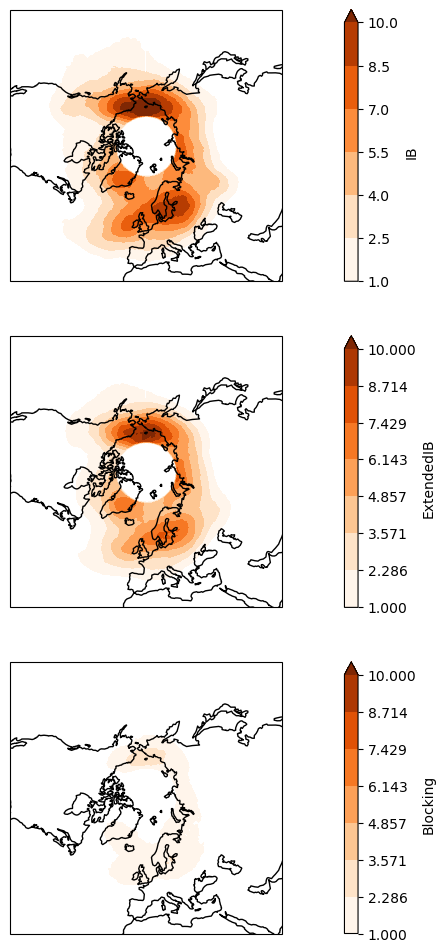

In [15]:

###=== plotting
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(16, 12), subplot_kw={'projection': ccrs.NorthPolarStereo()})
#fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.NorthPolarStereo()})
#std_djf.plot(ax=ax1,levels=np.linspace(200,800,11), cmap='YlOrRd', extend = 'both', transform=ccrs.PlateCarree(),add_colorbar=True)
#dstd_djf[0,:,:].
acc.plot.contourf(ax=ax1,levels = np.linspace(1,10,7),cmap='Oranges',extend = 'max', transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())

acc2.plot.contourf(ax=ax2,levels = np.linspace(1,10,8),cmap='Oranges',extend = 'max', transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())

acc3.plot.contourf(ax=ax3,levels = np.linspace(1,10,8),cmap='Oranges',extend = 'max', transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())

#acc.plot.contour(colors='grey', linewidths=0.8, levels = np.linspace(2,16,8), transform=ccrs.PlateCarree())





## Compute for whole period year by year

In [23]:
### open files
### nextgems
##xr_in=xr.open_mfdataset('/scratch/b/b382006/nextgems/prefinal/ngc4008/zg/daily/zg50000_icon_prefinal_day*')
###cmip6 ["MRI-ESM2-0","ACCESS-CM2","EC-Earth3","CESM2-WACCM","MIROC6","MPI-ESM1-2-HR","MPI-ESM1-2-LR","CESM2"]

exper='' #'ssp585'
inpath="/scratch/b/b382006/cmip6/"+exper+"/"
model="ACCESS-CM2"
member_id="r1i1p1f1"
infile=inpath+model+"/"+member_id+"/daily/50000/cmip6_zg_*"
#xr_in=xr.open_mfdataset(infile)

xr_in=xr.open_mfdataset('/work/bm1235/b382006/cmip6/ACCESS-CM2/r1i1p1f1/daily/????/Z*')


In [33]:
### Sel one pressure level of 500 hPa
xr_in=xr_in.sel(plev=50000., drop=True)

In [45]:
###==output
###nextgems
#dir_res='/scratch/b/b382006/nextgems/prefinal/ngc4008/block/ABS_Z500/'
##dir_res='/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ABS_Z500/'

###cmip6 
dir_res=inpath+model+"/"+member_id+"/block/ABS_500"

y0=1979 #2061 #1979, 2025, 2061
yn=2015 #2101 #2015, 2050, 2101
years=np.arange(y0,yn,1)

In [46]:
print(years,dir_res)

[1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014] /scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500


In [41]:
## ICON has GH, only rename it
### rename zfull
#xr_in=xr_in.rename({'zg':'GeopotentialHeight'})
#xr_in

In [42]:
### many warnings problem | use size to dertimine dimensions
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

for year in years:
    ofile= "block_ABS-Z500_"+str(year)+".nc"

    if not os.path.exists(dir_res):
        os.makedirs(dir_res)

    OUTPATH=dir_res+'/'+ofile

    print(OUTPATH)

    ### IFS Compute yearly
#    data=daily_z.sel(time=daily_z.time.dt.year.isin([year]))
    ### ICON Compute yearly
    data=xr_in.sel(time=xr_in.time.dt.year.isin([year]))

###=== intitate
    blk = Blocking()

    blk.import_xarray(data)

    ### not for ICON
    blk.calculate_gph_from_gp(gp_name='Z') # calculate geopotential height

    blk.set_up(time_name='time',longitude_name='lon', latitude_name='lat')

    blk.calculate_gradients(delta_degree=15)

    blk.calculate_ib(
    gradient_equator_below=0,
    gradient_pole_below=-10,
    gradient_equator2_above=5)

#
    blk.calculate_eib(min_extent_degree=15)

#
    blk.calculate_blocking(
    stationary_pm_days=2,
    longitude_pm_degree=8,
    latitude_pm_degree=2)

# save to disk
    blk
    blk.save(OUTPATH, 'Blocking')

    data.close()

2025-01-21 09:38:09,757 - root - INFO - Calculated GPH from GP
2025-01-21 09:38:09,764 - root - INFO - Set time grid distance 1
2025-01-21 09:38:09,765 - root - INFO - Set lon grid distance 1
2025-01-21 09:38:09,765 - root - INFO - Set lat grid distance 1.0
2025-01-21 09:38:09,767 - root - INFO - Calculate gradients as GeopotentialHeightGradient...


/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1979.nc


2025-01-21 09:38:10,069 - root - INFO - Calculating gradients... DONE
2025-01-21 09:38:10,070 - root - INFO - Calculating IB as IB...
2025-01-21 09:39:02,532 - root - INFO - Calculating IB... DONE
2025-01-21 09:39:02,589 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 09:39:03,161 - root - INFO - Calculating extended IB... DONE
2025-01-21 09:39:03,162 - root - INFO - Calculating blocking as Blocking...
2025-01-21 09:39:03,539 - root - INFO - Calculating time step... 0%
2025-01-21 09:39:15,398 - root - INFO - Calculating time step... 10%
2025-01-21 09:39:24,342 - root - INFO - Calculating time step... 20%
2025-01-21 09:39:39,619 - root - INFO - Calculating time step... 30%
2025-01-21 09:39:55,273 - root - INFO - Calculating time step... 40%
2025-01-21 09:40:12,339 - root - INFO - Calculating time step... 50%
2025-01-21 09:40:21,685 - root - INFO - Calculating time step... 60%
2025-01-21 09:40:29,494 - root - INFO - Calculating time step... 70%
2025-01-21 09:40:34,078

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1980.nc


2025-01-21 09:40:49,488 - root - INFO - Calculating gradients... DONE
2025-01-21 09:40:49,489 - root - INFO - Calculating IB as IB...
2025-01-21 09:41:51,294 - root - INFO - Calculating IB... DONE
2025-01-21 09:41:51,365 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 09:41:51,922 - root - INFO - Calculating extended IB... DONE
2025-01-21 09:41:51,923 - root - INFO - Calculating blocking as Blocking...
2025-01-21 09:41:52,100 - root - INFO - Calculating time step... 0%
2025-01-21 09:42:07,196 - root - INFO - Calculating time step... 10%
2025-01-21 09:42:17,394 - root - INFO - Calculating time step... 20%
2025-01-21 09:42:29,873 - root - INFO - Calculating time step... 30%
2025-01-21 09:42:37,061 - root - INFO - Calculating time step... 40%
2025-01-21 09:42:55,233 - root - INFO - Calculating time step... 50%
2025-01-21 09:43:09,920 - root - INFO - Calculating time step... 60%
2025-01-21 09:43:27,192 - root - INFO - Calculating time step... 70%
2025-01-21 09:43:34,214

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1981.nc


2025-01-21 09:44:01,933 - root - INFO - Calculated GPH from GP
2025-01-21 09:44:01,934 - root - INFO - Set time grid distance 1
2025-01-21 09:44:01,935 - root - INFO - Set lon grid distance 1
2025-01-21 09:44:01,935 - root - INFO - Set lat grid distance 1.0
2025-01-21 09:44:01,936 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 09:44:03,860 - root - INFO - Calculating gradients... DONE
2025-01-21 09:44:03,861 - root - INFO - Calculating IB as IB...
2025-01-21 09:45:04,325 - root - INFO - Calculating IB... DONE
2025-01-21 09:45:04,360 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 09:45:04,928 - root - INFO - Calculating extended IB... DONE
2025-01-21 09:45:04,929 - root - INFO - Calculating blocking as Blocking...
2025-01-21 09:45:05,133 - root - INFO - Calculating time step... 0%
2025-01-21 09:45:19,909 - root - INFO - Calculating time step... 10%
2025-01-21 09:45:32,830 - root - INFO - Calculating time step... 20%
2025-01-21 09:45:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1982.nc


2025-01-21 09:46:34,644 - root - INFO - Calculated GPH from GP
2025-01-21 09:46:34,645 - root - INFO - Set time grid distance 1
2025-01-21 09:46:34,645 - root - INFO - Set lon grid distance 1
2025-01-21 09:46:34,648 - root - INFO - Set lat grid distance 1.0
2025-01-21 09:46:34,648 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 09:46:34,974 - root - INFO - Calculating gradients... DONE
2025-01-21 09:46:34,974 - root - INFO - Calculating IB as IB...
2025-01-21 09:47:39,717 - root - INFO - Calculating IB... DONE
2025-01-21 09:47:39,856 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 09:47:40,430 - root - INFO - Calculating extended IB... DONE
2025-01-21 09:47:40,431 - root - INFO - Calculating blocking as Blocking...
2025-01-21 09:47:40,644 - root - INFO - Calculating time step... 0%
2025-01-21 09:47:59,644 - root - INFO - Calculating time step... 10%
2025-01-21 09:48:05,295 - root - INFO - Calculating time step... 20%
2025-01-21 09:48:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1983.nc


2025-01-21 09:49:32,522 - root - INFO - Calculating gradients... DONE
2025-01-21 09:49:32,523 - root - INFO - Calculating IB as IB...
2025-01-21 09:50:37,952 - root - INFO - Calculating IB... DONE
2025-01-21 09:50:38,031 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 09:50:38,612 - root - INFO - Calculating extended IB... DONE
2025-01-21 09:50:38,613 - root - INFO - Calculating blocking as Blocking...
2025-01-21 09:50:38,817 - root - INFO - Calculating time step... 0%
2025-01-21 09:50:48,187 - root - INFO - Calculating time step... 10%
2025-01-21 09:51:03,427 - root - INFO - Calculating time step... 20%
2025-01-21 09:51:19,376 - root - INFO - Calculating time step... 30%
2025-01-21 09:51:28,746 - root - INFO - Calculating time step... 40%
2025-01-21 09:51:35,403 - root - INFO - Calculating time step... 50%
2025-01-21 09:51:42,836 - root - INFO - Calculating time step... 60%
2025-01-21 09:51:52,346 - root - INFO - Calculating time step... 70%
2025-01-21 09:52:06,024

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1984.nc


2025-01-21 09:52:29,057 - root - INFO - Calculating gradients... DONE
2025-01-21 09:52:29,058 - root - INFO - Calculating IB as IB...
2025-01-21 09:53:41,724 - root - INFO - Calculating IB... DONE
2025-01-21 09:53:41,753 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 09:53:42,281 - root - INFO - Calculating extended IB... DONE
2025-01-21 09:53:42,282 - root - INFO - Calculating blocking as Blocking...
2025-01-21 09:53:42,439 - root - INFO - Calculating time step... 0%
2025-01-21 09:53:55,725 - root - INFO - Calculating time step... 10%
2025-01-21 09:54:09,859 - root - INFO - Calculating time step... 20%
2025-01-21 09:54:16,683 - root - INFO - Calculating time step... 30%
2025-01-21 09:54:24,582 - root - INFO - Calculating time step... 40%
2025-01-21 09:54:37,408 - root - INFO - Calculating time step... 50%
2025-01-21 09:54:49,059 - root - INFO - Calculating time step... 60%
2025-01-21 09:55:05,419 - root - INFO - Calculating time step... 70%
2025-01-21 09:55:12,947

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1985.nc


2025-01-21 09:55:28,675 - root - INFO - Calculated GPH from GP
2025-01-21 09:55:28,676 - root - INFO - Set time grid distance 1
2025-01-21 09:55:28,676 - root - INFO - Set lon grid distance 1
2025-01-21 09:55:28,678 - root - INFO - Set lat grid distance 1.0
2025-01-21 09:55:28,679 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 09:55:28,958 - root - INFO - Calculating gradients... DONE
2025-01-21 09:55:28,958 - root - INFO - Calculating IB as IB...
2025-01-21 09:56:32,730 - root - INFO - Calculating IB... DONE
2025-01-21 09:56:32,813 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 09:56:34,992 - root - INFO - Calculating extended IB... DONE
2025-01-21 09:56:34,996 - root - INFO - Calculating blocking as Blocking...
2025-01-21 09:56:35,193 - root - INFO - Calculating time step... 0%
2025-01-21 09:56:44,899 - root - INFO - Calculating time step... 10%
2025-01-21 09:57:05,569 - root - INFO - Calculating time step... 20%
2025-01-21 09:57:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1986.nc


2025-01-21 09:58:51,860 - root - INFO - Calculating gradients... DONE
2025-01-21 09:58:51,861 - root - INFO - Calculating IB as IB...
2025-01-21 09:59:58,476 - root - INFO - Calculating IB... DONE
2025-01-21 09:59:58,549 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 09:59:59,104 - root - INFO - Calculating extended IB... DONE
2025-01-21 09:59:59,105 - root - INFO - Calculating blocking as Blocking...
2025-01-21 09:59:59,279 - root - INFO - Calculating time step... 0%
2025-01-21 10:00:13,043 - root - INFO - Calculating time step... 10%
2025-01-21 10:00:28,976 - root - INFO - Calculating time step... 20%
2025-01-21 10:00:41,317 - root - INFO - Calculating time step... 30%
2025-01-21 10:00:56,024 - root - INFO - Calculating time step... 40%
2025-01-21 10:01:06,761 - root - INFO - Calculating time step... 50%
2025-01-21 10:01:17,582 - root - INFO - Calculating time step... 60%
2025-01-21 10:01:26,815 - root - INFO - Calculating time step... 70%
2025-01-21 10:01:34,207

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1987.nc


2025-01-21 10:01:57,304 - root - INFO - Calculated GPH from GP
2025-01-21 10:01:57,305 - root - INFO - Set time grid distance 1
2025-01-21 10:01:57,305 - root - INFO - Set lon grid distance 1
2025-01-21 10:01:57,306 - root - INFO - Set lat grid distance 1.0
2025-01-21 10:01:57,306 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 10:01:57,601 - root - INFO - Calculating gradients... DONE
2025-01-21 10:01:57,602 - root - INFO - Calculating IB as IB...
2025-01-21 10:03:04,780 - root - INFO - Calculating IB... DONE
2025-01-21 10:03:04,887 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 10:03:05,412 - root - INFO - Calculating extended IB... DONE
2025-01-21 10:03:05,413 - root - INFO - Calculating blocking as Blocking...
2025-01-21 10:03:05,585 - root - INFO - Calculating time step... 0%
2025-01-21 10:03:14,172 - root - INFO - Calculating time step... 10%
2025-01-21 10:03:26,780 - root - INFO - Calculating time step... 20%
2025-01-21 10:03:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1988.nc


2025-01-21 10:04:51,454 - root - INFO - Calculated GPH from GP
2025-01-21 10:04:51,455 - root - INFO - Set time grid distance 1
2025-01-21 10:04:51,456 - root - INFO - Set lon grid distance 1
2025-01-21 10:04:51,456 - root - INFO - Set lat grid distance 1.0
2025-01-21 10:04:51,457 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 10:04:51,739 - root - INFO - Calculating gradients... DONE
2025-01-21 10:04:51,740 - root - INFO - Calculating IB as IB...
2025-01-21 10:06:04,647 - root - INFO - Calculating IB... DONE
2025-01-21 10:06:04,718 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 10:06:05,260 - root - INFO - Calculating extended IB... DONE
2025-01-21 10:06:05,260 - root - INFO - Calculating blocking as Blocking...
2025-01-21 10:06:05,439 - root - INFO - Calculating time step... 0%
2025-01-21 10:06:13,308 - root - INFO - Calculating time step... 10%
2025-01-21 10:06:22,541 - root - INFO - Calculating time step... 20%
2025-01-21 10:06:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1989.nc


2025-01-21 10:07:56,777 - root - INFO - Calculated GPH from GP
2025-01-21 10:07:56,778 - root - INFO - Set time grid distance 1
2025-01-21 10:07:56,778 - root - INFO - Set lon grid distance 1
2025-01-21 10:07:56,780 - root - INFO - Set lat grid distance 1.0
2025-01-21 10:07:56,781 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 10:07:57,075 - root - INFO - Calculating gradients... DONE
2025-01-21 10:07:57,076 - root - INFO - Calculating IB as IB...
2025-01-21 10:09:00,601 - root - INFO - Calculating IB... DONE
2025-01-21 10:09:00,751 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 10:09:01,292 - root - INFO - Calculating extended IB... DONE
2025-01-21 10:09:01,293 - root - INFO - Calculating blocking as Blocking...
2025-01-21 10:09:01,484 - root - INFO - Calculating time step... 0%
2025-01-21 10:09:09,878 - root - INFO - Calculating time step... 10%
2025-01-21 10:09:26,012 - root - INFO - Calculating time step... 20%
2025-01-21 10:09:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1990.nc


2025-01-21 10:10:53,138 - root - INFO - Calculated GPH from GP
2025-01-21 10:10:53,145 - root - INFO - Set time grid distance 1
2025-01-21 10:10:53,145 - root - INFO - Set lon grid distance 1
2025-01-21 10:10:53,145 - root - INFO - Set lat grid distance 1.0
2025-01-21 10:10:53,147 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 10:10:53,442 - root - INFO - Calculating gradients... DONE
2025-01-21 10:10:53,442 - root - INFO - Calculating IB as IB...
2025-01-21 10:11:53,801 - root - INFO - Calculating IB... DONE
2025-01-21 10:11:53,825 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 10:11:54,330 - root - INFO - Calculating extended IB... DONE
2025-01-21 10:11:54,331 - root - INFO - Calculating blocking as Blocking...
2025-01-21 10:11:54,487 - root - INFO - Calculating time step... 0%
2025-01-21 10:12:07,140 - root - INFO - Calculating time step... 10%
2025-01-21 10:12:18,523 - root - INFO - Calculating time step... 20%
2025-01-21 10:12:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1991.nc


2025-01-21 10:13:48,972 - root - INFO - Calculating gradients... DONE
2025-01-21 10:13:48,973 - root - INFO - Calculating IB as IB...
2025-01-21 10:14:54,005 - root - INFO - Calculating IB... DONE
2025-01-21 10:14:54,081 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 10:14:54,618 - root - INFO - Calculating extended IB... DONE
2025-01-21 10:14:54,618 - root - INFO - Calculating blocking as Blocking...
2025-01-21 10:14:54,801 - root - INFO - Calculating time step... 0%
2025-01-21 10:15:05,169 - root - INFO - Calculating time step... 10%
2025-01-21 10:15:22,245 - root - INFO - Calculating time step... 20%
2025-01-21 10:15:35,338 - root - INFO - Calculating time step... 30%
2025-01-21 10:15:50,863 - root - INFO - Calculating time step... 40%
2025-01-21 10:16:07,440 - root - INFO - Calculating time step... 50%
2025-01-21 10:16:18,331 - root - INFO - Calculating time step... 60%
2025-01-21 10:16:29,010 - root - INFO - Calculating time step... 70%
2025-01-21 10:16:37,731

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1992.nc


2025-01-21 10:16:55,277 - root - INFO - Calculating gradients... DONE
2025-01-21 10:16:55,277 - root - INFO - Calculating IB as IB...
2025-01-21 10:18:05,780 - root - INFO - Calculating IB... DONE
2025-01-21 10:18:05,869 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 10:18:06,414 - root - INFO - Calculating extended IB... DONE
2025-01-21 10:18:06,415 - root - INFO - Calculating blocking as Blocking...
2025-01-21 10:18:06,604 - root - INFO - Calculating time step... 0%
2025-01-21 10:18:10,962 - root - INFO - Calculating time step... 10%
2025-01-21 10:18:24,615 - root - INFO - Calculating time step... 20%
2025-01-21 10:18:35,910 - root - INFO - Calculating time step... 30%
2025-01-21 10:18:47,354 - root - INFO - Calculating time step... 40%
2025-01-21 10:18:58,914 - root - INFO - Calculating time step... 50%
2025-01-21 10:19:09,621 - root - INFO - Calculating time step... 60%
2025-01-21 10:19:18,170 - root - INFO - Calculating time step... 70%
2025-01-21 10:19:31,821

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1993.nc


2025-01-21 10:19:48,919 - root - INFO - Calculating gradients... DONE
2025-01-21 10:19:48,919 - root - INFO - Calculating IB as IB...
2025-01-21 10:20:51,571 - root - INFO - Calculating IB... DONE
2025-01-21 10:20:51,648 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 10:20:54,116 - root - INFO - Calculating extended IB... DONE
2025-01-21 10:20:54,117 - root - INFO - Calculating blocking as Blocking...
2025-01-21 10:20:54,305 - root - INFO - Calculating time step... 0%
2025-01-21 10:21:11,128 - root - INFO - Calculating time step... 10%
2025-01-21 10:21:28,823 - root - INFO - Calculating time step... 20%
2025-01-21 10:21:49,972 - root - INFO - Calculating time step... 30%
2025-01-21 10:22:03,997 - root - INFO - Calculating time step... 40%
2025-01-21 10:22:13,918 - root - INFO - Calculating time step... 50%
2025-01-21 10:22:32,971 - root - INFO - Calculating time step... 60%
2025-01-21 10:22:44,672 - root - INFO - Calculating time step... 70%
2025-01-21 10:23:00,213

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1994.nc


2025-01-21 10:23:23,654 - root - INFO - Calculated GPH from GP
2025-01-21 10:23:23,656 - root - INFO - Set time grid distance 1
2025-01-21 10:23:23,656 - root - INFO - Set lon grid distance 1
2025-01-21 10:23:23,658 - root - INFO - Set lat grid distance 1.0
2025-01-21 10:23:23,658 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 10:23:23,987 - root - INFO - Calculating gradients... DONE
2025-01-21 10:23:23,988 - root - INFO - Calculating IB as IB...
2025-01-21 10:24:30,083 - root - INFO - Calculating IB... DONE
2025-01-21 10:24:30,146 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 10:24:30,689 - root - INFO - Calculating extended IB... DONE
2025-01-21 10:24:30,689 - root - INFO - Calculating blocking as Blocking...
2025-01-21 10:24:30,882 - root - INFO - Calculating time step... 0%
2025-01-21 10:24:38,853 - root - INFO - Calculating time step... 10%
2025-01-21 10:24:54,192 - root - INFO - Calculating time step... 20%
2025-01-21 10:25:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1995.nc


2025-01-21 10:26:46,915 - root - INFO - Calculated GPH from GP
2025-01-21 10:26:46,915 - root - INFO - Set time grid distance 1
2025-01-21 10:26:46,916 - root - INFO - Set lon grid distance 1
2025-01-21 10:26:46,917 - root - INFO - Set lat grid distance 1.0
2025-01-21 10:26:46,918 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 10:26:47,209 - root - INFO - Calculating gradients... DONE
2025-01-21 10:26:47,209 - root - INFO - Calculating IB as IB...
2025-01-21 10:27:55,182 - root - INFO - Calculating IB... DONE
2025-01-21 10:27:55,195 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 10:27:55,713 - root - INFO - Calculating extended IB... DONE
2025-01-21 10:27:55,714 - root - INFO - Calculating blocking as Blocking...
2025-01-21 10:27:55,892 - root - INFO - Calculating time step... 0%
2025-01-21 10:28:09,627 - root - INFO - Calculating time step... 10%
2025-01-21 10:28:25,008 - root - INFO - Calculating time step... 20%
2025-01-21 10:28:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1996.nc


2025-01-21 10:29:56,264 - root - INFO - Calculated GPH from GP
2025-01-21 10:29:56,265 - root - INFO - Set time grid distance 1
2025-01-21 10:29:56,266 - root - INFO - Set lon grid distance 1
2025-01-21 10:29:56,267 - root - INFO - Set lat grid distance 1.0
2025-01-21 10:29:56,268 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 10:29:56,594 - root - INFO - Calculating gradients... DONE
2025-01-21 10:29:56,595 - root - INFO - Calculating IB as IB...
2025-01-21 10:31:00,545 - root - INFO - Calculating IB... DONE
2025-01-21 10:31:00,692 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 10:31:02,962 - root - INFO - Calculating extended IB... DONE
2025-01-21 10:31:02,963 - root - INFO - Calculating blocking as Blocking...
2025-01-21 10:31:03,170 - root - INFO - Calculating time step... 0%
2025-01-21 10:31:11,449 - root - INFO - Calculating time step... 10%
2025-01-21 10:31:27,723 - root - INFO - Calculating time step... 20%
2025-01-21 10:31:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1997.nc


2025-01-21 10:32:47,436 - root - INFO - Set time grid distance 1
2025-01-21 10:32:47,436 - root - INFO - Set lon grid distance 1
2025-01-21 10:32:47,437 - root - INFO - Set lat grid distance 1.0
2025-01-21 10:32:47,438 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 10:32:47,700 - root - INFO - Calculating gradients... DONE
2025-01-21 10:32:47,701 - root - INFO - Calculating IB as IB...
2025-01-21 10:33:51,707 - root - INFO - Calculating IB... DONE
2025-01-21 10:33:51,735 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 10:33:52,218 - root - INFO - Calculating extended IB... DONE
2025-01-21 10:33:52,218 - root - INFO - Calculating blocking as Blocking...
2025-01-21 10:33:52,394 - root - INFO - Calculating time step... 0%
2025-01-21 10:34:00,246 - root - INFO - Calculating time step... 10%
2025-01-21 10:34:06,338 - root - INFO - Calculating time step... 20%
2025-01-21 10:34:20,075 - root - INFO - Calculating time step... 30%
2025-01-21 

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1998.nc


2025-01-21 10:35:27,895 - root - INFO - Calculated GPH from GP
2025-01-21 10:35:27,896 - root - INFO - Set time grid distance 1
2025-01-21 10:35:27,896 - root - INFO - Set lon grid distance 1
2025-01-21 10:35:27,901 - root - INFO - Set lat grid distance 1.0
2025-01-21 10:35:27,902 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 10:35:28,253 - root - INFO - Calculating gradients... DONE
2025-01-21 10:35:28,254 - root - INFO - Calculating IB as IB...
2025-01-21 10:36:34,589 - root - INFO - Calculating IB... DONE
2025-01-21 10:36:34,645 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 10:36:35,160 - root - INFO - Calculating extended IB... DONE
2025-01-21 10:36:35,160 - root - INFO - Calculating blocking as Blocking...
2025-01-21 10:36:35,409 - root - INFO - Calculating time step... 0%
2025-01-21 10:36:42,705 - root - INFO - Calculating time step... 10%
2025-01-21 10:37:01,233 - root - INFO - Calculating time step... 20%
2025-01-21 10:37:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_1999.nc


2025-01-21 10:38:43,349 - root - INFO - Calculated GPH from GP
2025-01-21 10:38:43,350 - root - INFO - Set time grid distance 1
2025-01-21 10:38:43,351 - root - INFO - Set lon grid distance 1
2025-01-21 10:38:43,353 - root - INFO - Set lat grid distance 1.0
2025-01-21 10:38:43,353 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 10:38:43,687 - root - INFO - Calculating gradients... DONE
2025-01-21 10:38:43,687 - root - INFO - Calculating IB as IB...
2025-01-21 10:39:54,151 - root - INFO - Calculating IB... DONE
2025-01-21 10:39:54,278 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 10:39:54,955 - root - INFO - Calculating extended IB... DONE
2025-01-21 10:39:54,989 - root - INFO - Calculating blocking as Blocking...
2025-01-21 10:39:55,182 - root - INFO - Calculating time step... 0%
2025-01-21 10:40:10,148 - root - INFO - Calculating time step... 10%
2025-01-21 10:40:21,942 - root - INFO - Calculating time step... 20%
2025-01-21 10:40:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_2000.nc


2025-01-21 10:42:13,408 - root - INFO - Calculated GPH from GP
2025-01-21 10:42:13,410 - root - INFO - Set time grid distance 1
2025-01-21 10:42:13,410 - root - INFO - Set lon grid distance 1
2025-01-21 10:42:13,411 - root - INFO - Set lat grid distance 1.0
2025-01-21 10:42:13,412 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 10:42:13,718 - root - INFO - Calculating gradients... DONE
2025-01-21 10:42:13,719 - root - INFO - Calculating IB as IB...
2025-01-21 10:43:19,225 - root - INFO - Calculating IB... DONE
2025-01-21 10:43:19,259 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 10:43:19,830 - root - INFO - Calculating extended IB... DONE
2025-01-21 10:43:19,830 - root - INFO - Calculating blocking as Blocking...
2025-01-21 10:43:20,038 - root - INFO - Calculating time step... 0%
2025-01-21 10:43:27,547 - root - INFO - Calculating time step... 10%
2025-01-21 10:43:41,407 - root - INFO - Calculating time step... 20%
2025-01-21 10:43:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_2001.nc


2025-01-21 10:45:07,281 - root - INFO - Set lat grid distance 1.0
2025-01-21 10:45:07,281 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 10:45:07,586 - root - INFO - Calculating gradients... DONE
2025-01-21 10:45:07,587 - root - INFO - Calculating IB as IB...
2025-01-21 10:46:19,092 - root - INFO - Calculating IB... DONE
2025-01-21 10:46:19,213 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 10:46:19,866 - root - INFO - Calculating extended IB... DONE
2025-01-21 10:46:19,883 - root - INFO - Calculating blocking as Blocking...
2025-01-21 10:46:20,092 - root - INFO - Calculating time step... 0%
2025-01-21 10:46:33,405 - root - INFO - Calculating time step... 10%
2025-01-21 10:46:42,742 - root - INFO - Calculating time step... 20%
2025-01-21 10:46:54,588 - root - INFO - Calculating time step... 30%
2025-01-21 10:47:10,191 - root - INFO - Calculating time step... 40%
2025-01-21 10:47:22,757 - root - INFO - Calculating time step... 50%
20

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_2002.nc


2025-01-21 10:48:19,721 - root - INFO - Calculated GPH from GP
2025-01-21 10:48:19,724 - root - INFO - Set time grid distance 1
2025-01-21 10:48:19,725 - root - INFO - Set lon grid distance 1
2025-01-21 10:48:19,725 - root - INFO - Set lat grid distance 1.0
2025-01-21 10:48:19,726 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 10:48:20,030 - root - INFO - Calculating gradients... DONE
2025-01-21 10:48:20,031 - root - INFO - Calculating IB as IB...
2025-01-21 10:49:31,386 - root - INFO - Calculating IB... DONE
2025-01-21 10:49:31,472 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 10:49:32,167 - root - INFO - Calculating extended IB... DONE
2025-01-21 10:49:32,226 - root - INFO - Calculating blocking as Blocking...
2025-01-21 10:49:32,470 - root - INFO - Calculating time step... 0%
2025-01-21 10:49:44,288 - root - INFO - Calculating time step... 10%
2025-01-21 10:49:55,655 - root - INFO - Calculating time step... 20%
2025-01-21 10:50:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_2003.nc


2025-01-21 10:51:15,212 - root - INFO - Set time grid distance 1
2025-01-21 10:51:15,212 - root - INFO - Set lon grid distance 1
2025-01-21 10:51:15,213 - root - INFO - Set lat grid distance 1.0
2025-01-21 10:51:15,213 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 10:51:15,528 - root - INFO - Calculating gradients... DONE
2025-01-21 10:51:15,529 - root - INFO - Calculating IB as IB...
2025-01-21 10:52:20,181 - root - INFO - Calculating IB... DONE
2025-01-21 10:52:20,294 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 10:52:20,839 - root - INFO - Calculating extended IB... DONE
2025-01-21 10:52:20,840 - root - INFO - Calculating blocking as Blocking...
2025-01-21 10:52:21,041 - root - INFO - Calculating time step... 0%
2025-01-21 10:52:34,754 - root - INFO - Calculating time step... 10%
2025-01-21 10:52:49,507 - root - INFO - Calculating time step... 20%
2025-01-21 10:53:05,792 - root - INFO - Calculating time step... 30%
2025-01-21 

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_2004.nc


2025-01-21 10:54:20,429 - root - INFO - Calculating gradients... DONE
2025-01-21 10:54:20,430 - root - INFO - Calculating IB as IB...
2025-01-21 10:55:25,220 - root - INFO - Calculating IB... DONE
2025-01-21 10:55:25,286 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 10:55:25,822 - root - INFO - Calculating extended IB... DONE
2025-01-21 10:55:25,823 - root - INFO - Calculating blocking as Blocking...
2025-01-21 10:55:25,997 - root - INFO - Calculating time step... 0%
2025-01-21 10:55:44,500 - root - INFO - Calculating time step... 10%
2025-01-21 10:55:57,572 - root - INFO - Calculating time step... 20%
2025-01-21 10:56:09,588 - root - INFO - Calculating time step... 30%
2025-01-21 10:56:17,208 - root - INFO - Calculating time step... 40%
2025-01-21 10:56:21,458 - root - INFO - Calculating time step... 50%
2025-01-21 10:56:30,454 - root - INFO - Calculating time step... 60%
2025-01-21 10:56:42,217 - root - INFO - Calculating time step... 70%
2025-01-21 10:56:54,764

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_2005.nc


2025-01-21 10:57:15,393 - root - INFO - Calculated GPH from GP
2025-01-21 10:57:15,394 - root - INFO - Set time grid distance 1
2025-01-21 10:57:15,395 - root - INFO - Set lon grid distance 1
2025-01-21 10:57:15,396 - root - INFO - Set lat grid distance 1.0
2025-01-21 10:57:15,396 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 10:57:17,287 - root - INFO - Calculating gradients... DONE
2025-01-21 10:57:17,290 - root - INFO - Calculating IB as IB...
2025-01-21 10:58:26,025 - root - INFO - Calculating IB... DONE
2025-01-21 10:58:26,079 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 10:58:26,640 - root - INFO - Calculating extended IB... DONE
2025-01-21 10:58:26,641 - root - INFO - Calculating blocking as Blocking...
2025-01-21 10:58:26,845 - root - INFO - Calculating time step... 0%
2025-01-21 10:58:36,965 - root - INFO - Calculating time step... 10%
2025-01-21 10:58:46,449 - root - INFO - Calculating time step... 20%
2025-01-21 10:58:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_2006.nc


2025-01-21 11:00:14,274 - root - INFO - Calculated GPH from GP
2025-01-21 11:00:14,275 - root - INFO - Set time grid distance 1
2025-01-21 11:00:14,275 - root - INFO - Set lon grid distance 1
2025-01-21 11:00:14,278 - root - INFO - Set lat grid distance 1.0
2025-01-21 11:00:14,278 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 11:00:14,581 - root - INFO - Calculating gradients... DONE
2025-01-21 11:00:14,582 - root - INFO - Calculating IB as IB...
2025-01-21 11:01:27,780 - root - INFO - Calculating IB... DONE
2025-01-21 11:01:27,854 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 11:01:28,417 - root - INFO - Calculating extended IB... DONE
2025-01-21 11:01:28,418 - root - INFO - Calculating blocking as Blocking...
2025-01-21 11:01:28,598 - root - INFO - Calculating time step... 0%
2025-01-21 11:01:40,332 - root - INFO - Calculating time step... 10%
2025-01-21 11:01:57,534 - root - INFO - Calculating time step... 20%
2025-01-21 11:02:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_2007.nc


2025-01-21 11:03:08,325 - root - INFO - Calculating gradients... DONE
2025-01-21 11:03:08,326 - root - INFO - Calculating IB as IB...
2025-01-21 11:04:24,030 - root - INFO - Calculating IB... DONE
2025-01-21 11:04:24,134 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 11:04:26,425 - root - INFO - Calculating extended IB... DONE
2025-01-21 11:04:26,426 - root - INFO - Calculating blocking as Blocking...
2025-01-21 11:04:26,631 - root - INFO - Calculating time step... 0%
2025-01-21 11:04:42,218 - root - INFO - Calculating time step... 10%
2025-01-21 11:04:50,932 - root - INFO - Calculating time step... 20%
2025-01-21 11:04:57,817 - root - INFO - Calculating time step... 30%
2025-01-21 11:05:06,737 - root - INFO - Calculating time step... 40%
2025-01-21 11:05:13,728 - root - INFO - Calculating time step... 50%
2025-01-21 11:05:25,936 - root - INFO - Calculating time step... 60%
2025-01-21 11:05:39,656 - root - INFO - Calculating time step... 70%
2025-01-21 11:05:51,826

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_2008.nc


2025-01-21 11:06:11,143 - root - INFO - Calculated GPH from GP
2025-01-21 11:06:11,144 - root - INFO - Set time grid distance 1
2025-01-21 11:06:11,144 - root - INFO - Set lon grid distance 1
2025-01-21 11:06:11,146 - root - INFO - Set lat grid distance 1.0
2025-01-21 11:06:11,147 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 11:06:11,534 - root - INFO - Calculating gradients... DONE
2025-01-21 11:06:11,535 - root - INFO - Calculating IB as IB...
2025-01-21 11:07:25,942 - root - INFO - Calculating IB... DONE
2025-01-21 11:07:26,220 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 11:07:26,781 - root - INFO - Calculating extended IB... DONE
2025-01-21 11:07:26,782 - root - INFO - Calculating blocking as Blocking...
2025-01-21 11:07:26,979 - root - INFO - Calculating time step... 0%
2025-01-21 11:07:42,179 - root - INFO - Calculating time step... 10%
2025-01-21 11:07:57,525 - root - INFO - Calculating time step... 20%
2025-01-21 11:08:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_2009.nc


2025-01-21 11:09:27,330 - root - INFO - Calculated GPH from GP
2025-01-21 11:09:27,331 - root - INFO - Set time grid distance 1
2025-01-21 11:09:27,332 - root - INFO - Set lon grid distance 1
2025-01-21 11:09:27,334 - root - INFO - Set lat grid distance 1.0
2025-01-21 11:09:27,334 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 11:09:27,652 - root - INFO - Calculating gradients... DONE
2025-01-21 11:09:27,653 - root - INFO - Calculating IB as IB...
2025-01-21 11:10:36,957 - root - INFO - Calculating IB... DONE
2025-01-21 11:10:36,958 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 11:10:37,486 - root - INFO - Calculating extended IB... DONE
2025-01-21 11:10:37,487 - root - INFO - Calculating blocking as Blocking...
2025-01-21 11:10:37,669 - root - INFO - Calculating time step... 0%
2025-01-21 11:10:49,657 - root - INFO - Calculating time step... 10%
2025-01-21 11:11:01,725 - root - INFO - Calculating time step... 20%
2025-01-21 11:11:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_2010.nc


2025-01-21 11:12:30,392 - root - INFO - Calculated GPH from GP
2025-01-21 11:12:30,393 - root - INFO - Set time grid distance 1
2025-01-21 11:12:30,394 - root - INFO - Set lon grid distance 1
2025-01-21 11:12:30,395 - root - INFO - Set lat grid distance 1.0
2025-01-21 11:12:30,395 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 11:12:30,742 - root - INFO - Calculating gradients... DONE
2025-01-21 11:12:30,743 - root - INFO - Calculating IB as IB...
2025-01-21 11:13:40,132 - root - INFO - Calculating IB... DONE
2025-01-21 11:13:40,246 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 11:13:42,566 - root - INFO - Calculating extended IB... DONE
2025-01-21 11:13:42,566 - root - INFO - Calculating blocking as Blocking...
2025-01-21 11:13:42,746 - root - INFO - Calculating time step... 0%
2025-01-21 11:13:53,175 - root - INFO - Calculating time step... 10%
2025-01-21 11:14:12,333 - root - INFO - Calculating time step... 20%
2025-01-21 11:14:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_2011.nc


2025-01-21 11:15:44,118 - root - INFO - Calculating gradients... DONE
2025-01-21 11:15:44,118 - root - INFO - Calculating IB as IB...
2025-01-21 11:16:57,448 - root - INFO - Calculating IB... DONE
2025-01-21 11:16:57,537 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 11:16:58,214 - root - INFO - Calculating extended IB... DONE
2025-01-21 11:16:58,265 - root - INFO - Calculating blocking as Blocking...
2025-01-21 11:16:58,496 - root - INFO - Calculating time step... 0%
2025-01-21 11:17:05,763 - root - INFO - Calculating time step... 10%
2025-01-21 11:17:22,844 - root - INFO - Calculating time step... 20%
2025-01-21 11:17:33,849 - root - INFO - Calculating time step... 30%
2025-01-21 11:17:39,900 - root - INFO - Calculating time step... 40%
2025-01-21 11:17:53,691 - root - INFO - Calculating time step... 50%
2025-01-21 11:18:03,645 - root - INFO - Calculating time step... 60%
2025-01-21 11:18:13,143 - root - INFO - Calculating time step... 70%
2025-01-21 11:18:20,648

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_2012.nc


2025-01-21 11:18:36,614 - root - INFO - Calculated GPH from GP
2025-01-21 11:18:36,615 - root - INFO - Set time grid distance 1
2025-01-21 11:18:36,616 - root - INFO - Set lon grid distance 1
2025-01-21 11:18:36,617 - root - INFO - Set lat grid distance 1.0
2025-01-21 11:18:36,618 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 11:18:36,894 - root - INFO - Calculating gradients... DONE
2025-01-21 11:18:36,895 - root - INFO - Calculating IB as IB...
2025-01-21 11:19:42,828 - root - INFO - Calculating IB... DONE
2025-01-21 11:19:42,838 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 11:19:43,330 - root - INFO - Calculating extended IB... DONE
2025-01-21 11:19:43,331 - root - INFO - Calculating blocking as Blocking...
2025-01-21 11:19:43,844 - root - INFO - Calculating time step... 0%
2025-01-21 11:19:58,621 - root - INFO - Calculating time step... 10%
2025-01-21 11:20:18,563 - root - INFO - Calculating time step... 20%
2025-01-21 11:20:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_2013.nc


2025-01-21 11:21:45,967 - root - INFO - Calculated GPH from GP
2025-01-21 11:21:45,973 - root - INFO - Set time grid distance 1
2025-01-21 11:21:45,974 - root - INFO - Set lon grid distance 1
2025-01-21 11:21:45,974 - root - INFO - Set lat grid distance 1.0
2025-01-21 11:21:45,975 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 11:21:46,271 - root - INFO - Calculating gradients... DONE
2025-01-21 11:21:46,271 - root - INFO - Calculating IB as IB...
2025-01-21 11:22:54,718 - root - INFO - Calculating IB... DONE
2025-01-21 11:22:54,756 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 11:22:57,021 - root - INFO - Calculating extended IB... DONE
2025-01-21 11:22:57,022 - root - INFO - Calculating blocking as Blocking...
2025-01-21 11:22:57,200 - root - INFO - Calculating time step... 0%
2025-01-21 11:23:05,479 - root - INFO - Calculating time step... 10%
2025-01-21 11:23:15,561 - root - INFO - Calculating time step... 20%
2025-01-21 11:23:

/scratch/b/b382006/cmip6//ACCESS-CM2/r1i1p1f1/block/ABS_500/block_ABS-Z500_2014.nc


2025-01-21 11:24:25,928 - root - INFO - Calculated GPH from GP
2025-01-21 11:24:25,933 - root - INFO - Set time grid distance 1
2025-01-21 11:24:25,934 - root - INFO - Set lon grid distance 1
2025-01-21 11:24:25,935 - root - INFO - Set lat grid distance 1.0
2025-01-21 11:24:25,935 - root - INFO - Calculate gradients as GeopotentialHeightGradient...
2025-01-21 11:24:26,281 - root - INFO - Calculating gradients... DONE
2025-01-21 11:24:26,299 - root - INFO - Calculating IB as IB...
2025-01-21 11:25:30,079 - root - INFO - Calculating IB... DONE
2025-01-21 11:25:30,085 - root - INFO - Calculating extended IB as ExtendedIB...
2025-01-21 11:25:30,615 - root - INFO - Calculating extended IB... DONE
2025-01-21 11:25:30,616 - root - INFO - Calculating blocking as Blocking...
2025-01-21 11:25:30,793 - root - INFO - Calculating time step... 0%
2025-01-21 11:25:33,713 - root - INFO - Calculating time step... 10%
2025-01-21 11:25:43,911 - root - INFO - Calculating time step... 20%
2025-01-21 11:25:

In [44]:
### Compute average
#OUTPATH

In [10]:
### versus ERA5

## Analyzing outputs (frequency)

In [31]:
### Time series
###===IFS
#inpath='/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/block/ABS_Z500/'
###===ICON
#inpath='/scratch/b/b382006/nextgems/prefinal/ngc4008/block/ABS_Z500/'
###acc_era5.plot()

In [28]:
#block = xr.open_mfdataset(inpath+'block_ABS-Z500*')
#ntime=len(block.time)
#ntime
ifs_z500_day

sample=ifs_z500_day.sel(lat=slice(0,90))

tserie=sample.mean(dim=["lat", "lon"])
tserie
##tserie['Blocking']
#tmp=xr.where(tserie['Blocking']>0,1,0).compute()
#serie=tmp.groupby("time.year").sum()

<xarray.Dataset>
Dimensions:   (time: 10957)
Coordinates:
  * time      (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2019-12-31
Data variables:
    Blocking  (time) float64 0.01792 0.01316 0.004762 ... 0.002289 0.005067

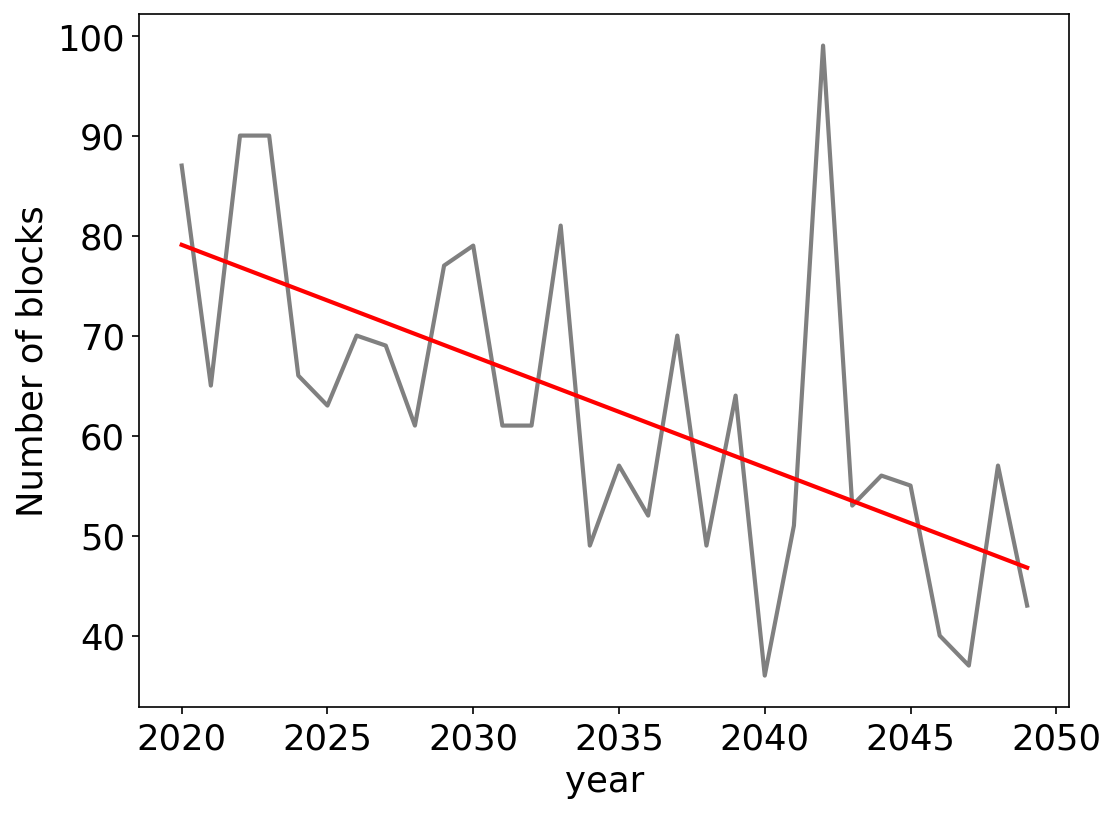

In [71]:
### Computing trend
###NA
sample=block.sel(lat=slice(40,65),lon=slice(5,40))
###NP
#sample=block.sel(lat=slice(50,75),lon=slice(160,180))
tserie=sample.mean(dim=["lat", "lon"])
#tserie['Blocking']
tmp=xr.where(tserie['Blocking']>0,1,0).compute()
serie=tmp.groupby("time.year").sum()

x=np.arange(serie.size)
fit=np.polyfit(x,serie.values,1)
fit_fn=np.poly1d(fit)

### Plot
fig,ax=plt.subplots(figsize=(8, 6), dpi=150)
serie.plot(color='grey', linestyle='-',lw=2)
plt.ylabel('Number of blocks', fontsize=17)
plt.xlabel('year',fontsize=17)
plt.plot(serie.year,fit_fn(x),'r-',lw=2)

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

In [72]:
### Compute frequency by periods